In [1]:
# 5 frame sequence 640x480 png grayscale

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage import transform
from skimage import util
from skimage import exposure

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


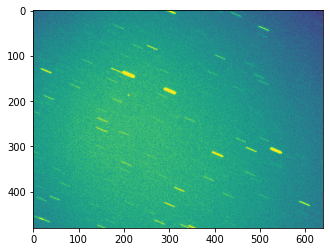

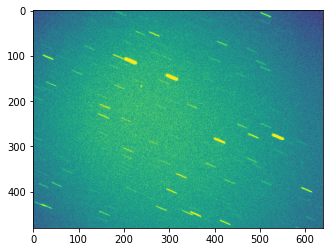

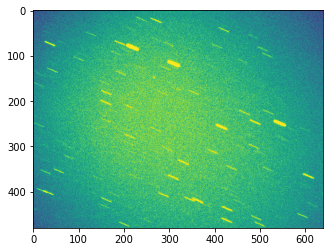

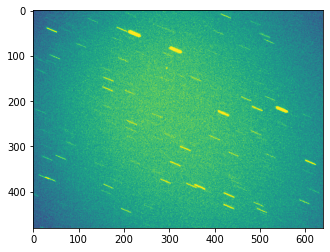

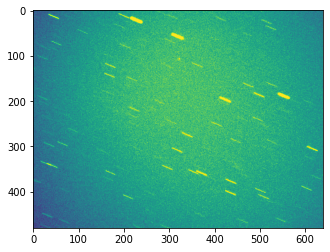

In [267]:
seqid = 839

frames = [util.img_as_float(imread(f"../spotGEO/train/{seqid}/{i}.png", as_gray=True)) for i in range(1, 6)]
frames = [exposure.rescale_intensity(frame) for frame in frames]

for frame in frames:
    print( np.min(frame.ravel()), np.max(frame.ravel()) )
    
for frame in frames:
    plt.imshow(frame)
    plt.show()

In [265]:
from skimage.feature import match_descriptors, ORB, plot_matches
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform, SimilarityTransform


def process(Ifix, Imove):
    # np.random.seed(0)
    
    img_left, img_right = Ifix.copy(), Imove.copy()
    # img_left, img_right = map(rgb2gray, (img_left, img_right))

    # Find sparse feature correspondences between left and right image.
    descriptor_extractor = ORB()

    descriptor_extractor.detect_and_extract(img_left)
    keypoints_left = descriptor_extractor.keypoints
    descriptors_left = descriptor_extractor.descriptors

    descriptor_extractor.detect_and_extract(img_right)
    keypoints_right = descriptor_extractor.keypoints
    descriptors_right = descriptor_extractor.descriptors

    matches = match_descriptors(descriptors_left, descriptors_right, cross_check=True)
    
    x = np.flip(keypoints_left[matches[:, 0]], axis=1)
    y = np.flip(keypoints_right[matches[:, 1]], axis=1)

    min_samples = 4
    
    model, inliers = ransac((x, y),
                            SimilarityTransform, min_samples=min_samples,
                            residual_threshold=1, max_trials=5000//50)
    
    return model

In [266]:
# frames = [util.img_as_float(imread(f"../spotGEO/train/{seqid}/{i}.png", as_gray=True)) for i in range(1, 6)]

T1 = process(frames[0], frames[1])
T2 = process(frames[1], frames[2])
T3 = process(frames[2], frames[3])
T4 = process(frames[3], frames[4])

/home/acer/.local/lib/python3.6/site-packages/skimage/transform/_geometric.py:101: RuntimeWarning: Mean of empty slice.
  src_mean = src.mean(axis=0)
/home/acer/.local/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/acer/.local/lib/python3.6/site-packages/skimage/transform/_geometric.py:102: RuntimeWarning: Mean of empty slice.
  dst_mean = dst.mean(axis=0)
/home/acer/.local/lib/python3.6/site-packages/skimage/transform/_geometric.py:109: RuntimeWarning: invalid value encountered in true_divide
  A = dst_demean.T @ src_demean / num
/home/acer/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/acer/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis

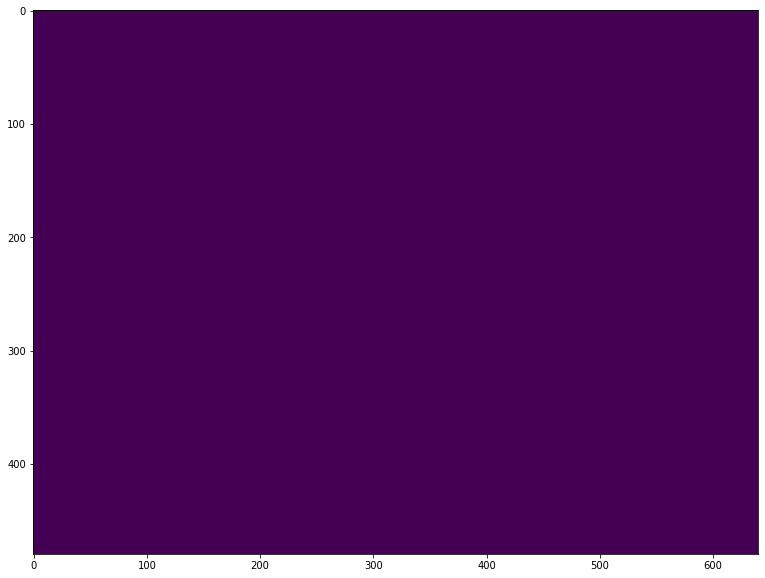

In [258]:
I4 = transform.warp(transform.warp(transform.warp(transform.warp(frames[4], T4), T3), T2), T1)
I3 = transform.warp(transform.warp(transform.warp(frames[3], T3), T2), T1)
I2 = transform.warp(transform.warp(frames[2], T2), T1)
I1 = transform.warp(frames[1], T1)
I0 = frames[0]

sequence = np.array([I0, I1, I2, I3, I4])
Iseq = np.max(sequence, axis=0)

plt.figure(figsize=(25, 10))
plt.imshow(Iseq)
plt.show()

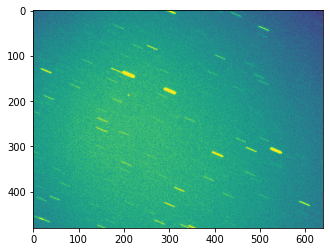

<SimilarityTransform(matrix=
    [[-4.90962902e-03, -1.30367196e-02,  5.59215962e+02],
     [ 1.30367196e-02, -4.90962902e-03,  2.80994175e+02],
     [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])>


In [263]:
plt.imshow(sequence[0])
plt.show()

print(T1)

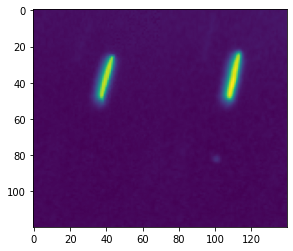

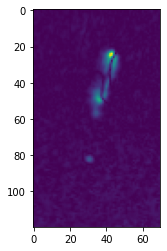

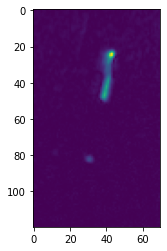

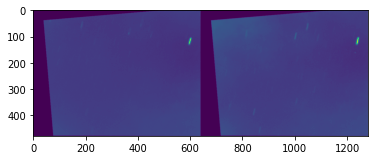

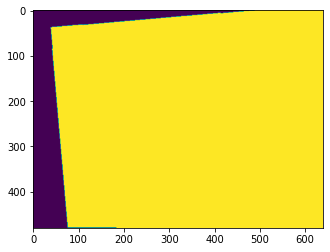

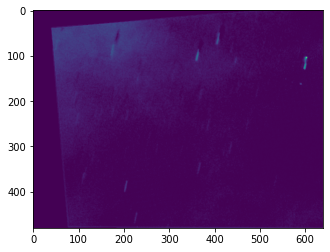

In [7]:
%matplotlib inline

from skimage import filters

Iseq3 = np.min(np.array([I0, I1, I2, I3]), axis=0)

plt.imshow(np.hstack([Iseq3[80:200,560:630], I3[80:200,560:630]]))
plt.show()

plt.imshow(np.absolute(I3[80:200,560:630] - filters.gaussian(I2)[80:200,560:630]))
plt.show()

plt.imshow(np.absolute(I3[80:200,560:630] - filters.gaussian(Iseq3)[80:200,560:630]))
plt.show()

plt.imshow(np.hstack([Iseq3, I3]))
plt.show()

plt.imshow( (Iseq3>0)*(I3>0) )
plt.show()

Idiff = np.absolute((I3 - filters.gaussian(Iseq3))*(I3>0)*(Iseq>0))

plt.imshow( Idiff )
plt.show()

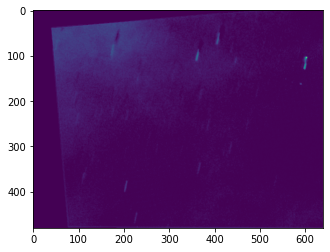

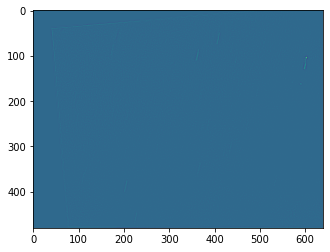

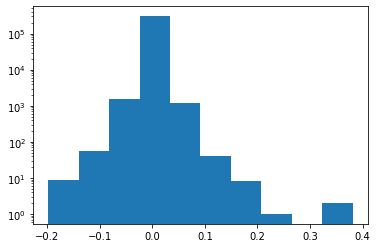

In [8]:
plt.imshow(Idiff)
plt.show()

plt.imshow(filters.laplace(Idiff))
plt.show()

plt.hist(filters.laplace(Idiff).ravel(), log=True)
plt.show()

Ilapl = filters.laplace(Idiff)

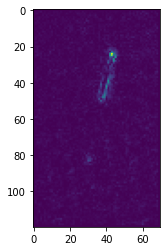

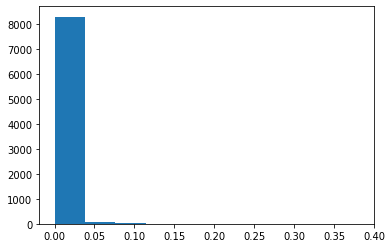

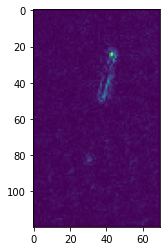

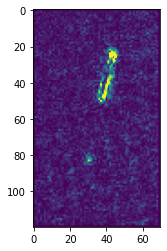

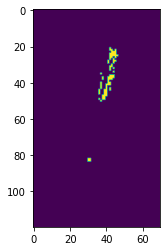

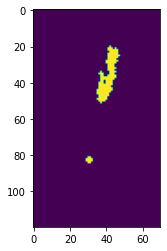

In [9]:
%matplotlib inline

from skimage import exposure

Idiffp = Idiff[80:200,560:630]

Idiffp = np.absolute(filters.laplace(Idiffp))
Idiffp_adj = exposure.adjust_log(Idiffp, 8)
Idiffp_blob = Idiffp_adj.copy()

# Idiffp_blob = np.absolute(filters.laplace(Idiffp_adj))

plt.imshow(Idiffp)
plt.show()

plt.hist(Idiffp.ravel())
plt.show()

plt.imshow(Idiffp_adj)
plt.show()


plt.imshow(Idiffp_blob, vmin=0, vmax=1)
plt.show()

plt.imshow(Idiffp_blob > 0.5, vmin=0, vmax=1)
plt.show()

from skimage import morphology

plt.imshow( morphology.binary_dilation(Idiffp_blob > 0.5) )
plt.show()

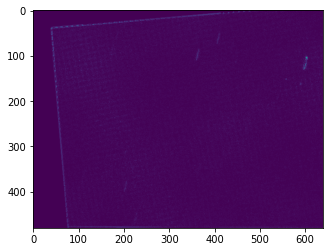

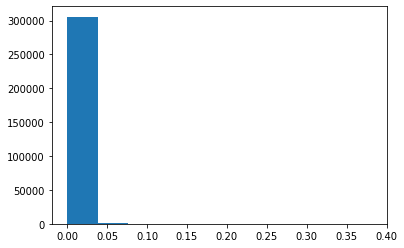

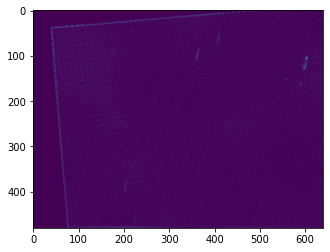

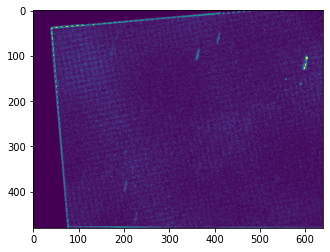

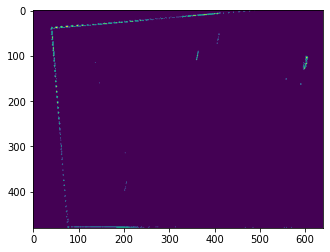

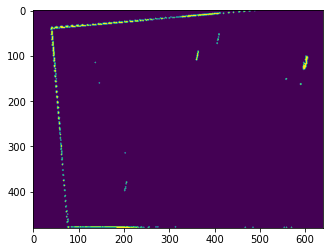

In [10]:
# Extend to all image

%matplotlib inline

from skimage import exposure

Idiffp = Idiff

Idiffp = np.absolute(filters.laplace(Idiffp))
Idiffp_adj = exposure.adjust_log(Idiffp, 8)
Idiffp_blob = Idiffp_adj.copy()

plt.imshow(Idiffp)
plt.show()

plt.hist(Idiffp.ravel())
plt.show()

plt.imshow(Idiffp_adj)
plt.show()


plt.imshow(Idiffp_blob, vmin=0, vmax=1)
plt.show()

plt.imshow(Idiffp_blob > 0.5, vmin=0, vmax=1)
plt.show()

from skimage import morphology

Iblobs = morphology.binary_dilation(Idiffp_blob > 0.5)

plt.imshow(Iblobs)
plt.show()

In [11]:
# Get object coordinates from json file
import json

def read_annotation_file(path):
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict


dataset = read_annotation_file('../spotGEO/train_anno.json')

objects = np.array([dataset[seqid][i] for i in range(1, 6)])

print(objects.shape)

(5, 1, 2)


<IPython.core.display.Javascript object>


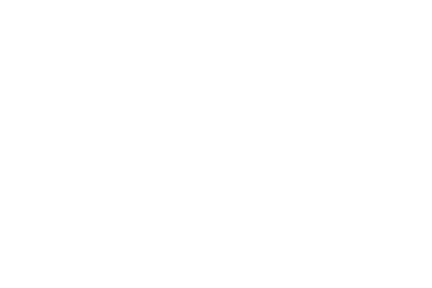

<IPython.core.display.Javascript object>


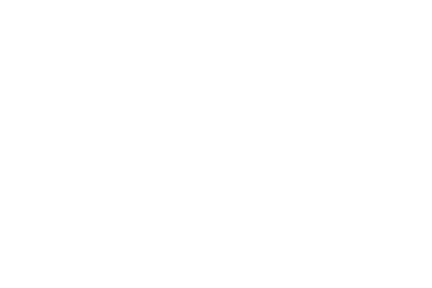

In [12]:
%matplotlib notebook

frame_n = 3

I = frames[frame_n]
target = objects[frame_n][0]

circle = plt.Circle(target, 10, color='r', fill=False)

plt.imshow(I)
plt.gcf().gca().add_artist(circle)

plt.show()

<IPython.core.display.Javascript object>


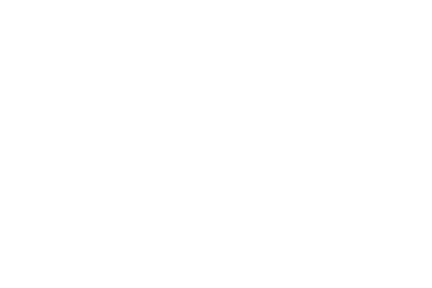

<IPython.core.display.Javascript object>


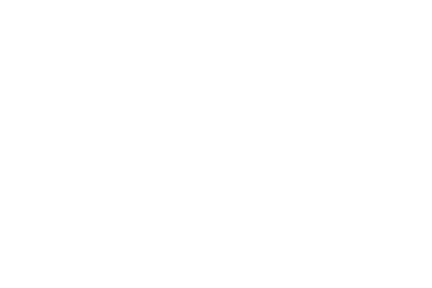

In [13]:
%matplotlib notebook

target0 = objects[0][0]
target1 = objects[1][0]
target2 = objects[2][0]
target3 = objects[3][0]
target4 = objects[4][0]

target1_t = transform.matrix_transform(target1, np.linalg.inv(T1.params))[0]
target2_t = transform.matrix_transform(target2, np.linalg.inv(T1.params) @ np.linalg.inv(T2.params))[0]
target3_t = transform.matrix_transform(target3, 
                                       np.linalg.inv(T3.params) @ np.linalg.inv(T2.params) @ np.linalg.inv(T1.params)
                                      )[0]
target4_t = transform.matrix_transform(target4, 
                                       np.linalg.inv(T4.params) @ np.linalg.inv(T3.params) @ np.linalg.inv(T2.params) @ np.linalg.inv(T1.params)
                                      )[0]

circle = plt.Circle(target0, 10, color='r', fill=False)
circle1 = plt.Circle(target1_t, 10, color='r', fill=False)
circle2 = plt.Circle(target2_t, 10, color='r', fill=False)
circle3 = plt.Circle(target3_t, 10, color='r', fill=False)
circle4 = plt.Circle(target4_t, 10, color='r', fill=False)

Iseq = np.max(sequence, axis=0)

plt.imshow(Iseq)
plt.gcf().gca().add_artist(circle)
plt.gcf().gca().add_artist(circle1)
plt.gcf().gca().add_artist(circle2)
plt.gcf().gca().add_artist(circle3)
plt.gcf().gca().add_artist(circle4)

plt.show()

In [14]:
I4 = transform.warp(transform.warp(transform.warp(transform.warp(frames[4], T4), T3), T2), T1)
I3 = transform.warp(transform.warp(transform.warp(frames[3], T3), T2), T1)
I2 = transform.warp(transform.warp(frames[2], T2), T1)
I1 = transform.warp(frames[1], T1)
I0 = frames[0]



# sequence = [I0, I1, I2, I3, I4]

# plt.figure(figsize=(25, 10))
# plt.imshow(0.2*I0 + 0.2*I4 + 0.2*I3 + 0.2*I2+0.2*I1)
# plt.show()

107
16
[590.59365986 158.38641152]
eccentricity 0.6741998624632421 area 6 max intensity 0.0565707592430269
132.16666666666666 112.83333333333333


<IPython.core.display.Javascript object>


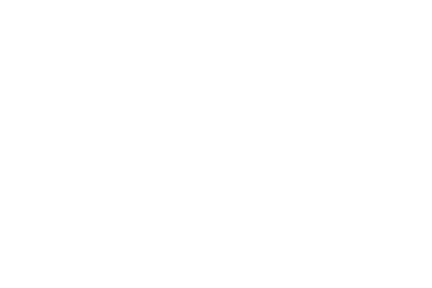

eccentricity 0.6945875203623408 area 9 max intensity 0.09080758790353319
162.11111111111111 590.6666666666666
eccentricity 0.7238845965239822 area 7 max intensity 0.056445787991159735
64.28571428571429 260.14285714285717
eccentricity 0.7384255845247096 area 8 max intensity 0.057866692559770144
78.25 262.75
eccentricity 0.8021087259367566 area 7 max intensity 0.054896789031047444
118.85714285714286 138.85714285714286
eccentricity 0.8468413944019119 area 9 max intensity 0.056326433836222545
125.33333333333333 182.66666666666666
eccentricity 0.847966925797316 area 6 max intensity 0.05268139723643117
122.83333333333333 136.83333333333334
eccentricity 0.8660670458276957 area 7 max intensity 0.05379958974147539
73.28571428571429 267.2857142857143
eccentricity 0.8703882797784891 area 6 max intensity 0.05462481946110037
94.0 239.16666666666666
eccentricity 0.9107813643508433 area 14 max intensity 0.05979910518383677
149.28571428571428 62.285714285714285


<IPython.core.display.Javascript object>


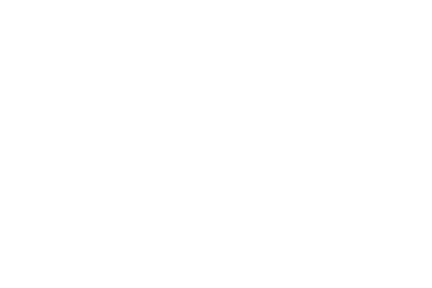

In [15]:
from skimage import measure
from skimage import color

Imask = Idiff > 0.05
Ilabels = measure.label(Imask, connectivity=2)
regions = measure.regionprops(Ilabels, Idiff)
            
# plt.imshow(color.label2rgb(Ilabels))
# plt.show()

print( len(regions) )

regions = [region for region in regions if region.centroid[0] > 5 and region.centroid[1] > 5]
regions = [region for region in regions if (region.max_intensity > 0.05) and (region.area > 5) and (region.area < 15)]

print( len(regions) )

regions = sorted(regions, key=lambda region: region.eccentricity)[:10]

print( target3_t )

for region in regions:
    
    print('eccentricity', region.eccentricity, 'area', region.area, 'max intensity', region.max_intensity)
    
    row, col = region.centroid
    print(row, col)
    
    Ibox = Imask[int(row-5):int(row+5), int(col-5):int(col+5)]
    Idiffp = Idiff[int(row-5):int(row+5), int(col-5):int(col+5)]
    
    plt.imshow(np.hstack([np.float64(Ibox), Idiffp]), vmin=0, vmax=1)
    plt.show()

(array([24, 47, 82]), array([43, 39, 31]))


<IPython.core.display.Javascript object>


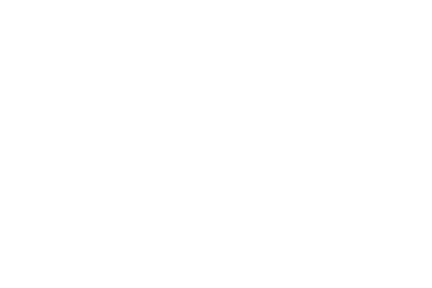

<IPython.core.display.Javascript object>


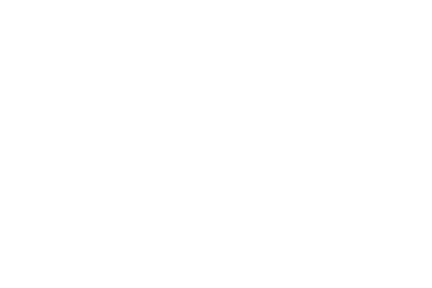

In [181]:
%matplotlib notebook

Idiffp = Idiff[80:200,560:630]
# Idiffp = np.zeros((3,3))
# Idiffp[1,1] = 1.0
# Idiffp[2,2] = 0.01
# Idiffp[10,10] = 0.5

# Imaxima = morphology.local_maxima(Idiffp, selem=morphology)
selem = morphology.square(9)
# selem = morphology.diamond(1)

# Imaxima = morphology.local_maxima(Idiffp, selem=selem)
Imaxima = morphology.h_maxima(Idiffp, 0.02, selem=selem)
idxs = np.where(Imaxima == 1)
print(idxs)

objid = 2

r0, c0 = idxs[0][objid], idxs[1][objid]

Iblob = Idiffp[r0-10:r0+10, c0-10:c0+10]

plt.imshow(Iblob, vmin=0, vmax=1)
plt.show()

0.9531612277204607


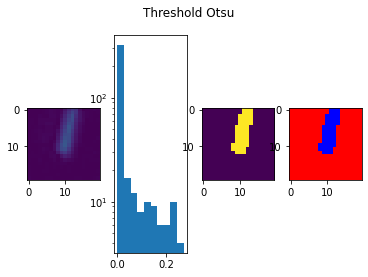

In [237]:
%matplotlib inline
from skimage import segmentation

objid = 1

r0, c0 = idxs[0][objid], idxs[1][objid]

Iblob = Idiffp[r0-10:r0+10, c0-10:c0+10]

Iin = Iblob

thresh = filters.threshold_otsu(util.img_as_ubyte(Iin))
Ithr = Iin > thresh/255
Ilabel = morphology.label(Ithr)

regions = measure.regionprops(Ilabel)

for region in regions:
    print(region.eccentricity)

fig, axs = plt.subplots(1,4)
axs[0].imshow(Iin, vmin=0, vmax=1)
axs[1].hist(Iin.ravel(), log=True)
axs[2].imshow(Ithr)
axs[3].imshow(color.label2rgb(Ilabel))

fig.suptitle('Threshold Otsu')
plt.show()

0.8703882797784892 50


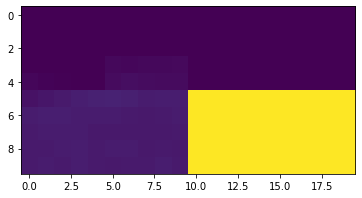

0.8703882797784892 50


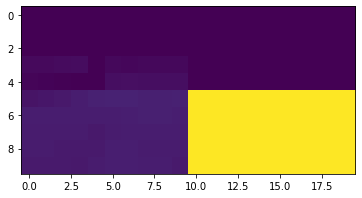

0.6075126862226182 29


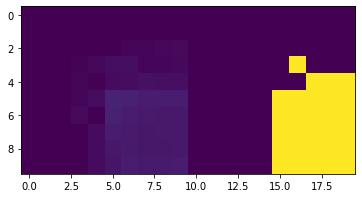

0.8659458873103918 51


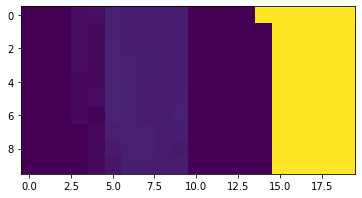

0.926057641816171 37


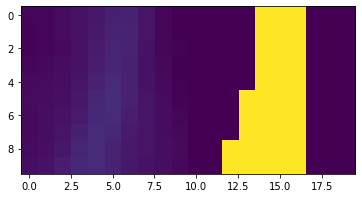

0.7092582268241713 52


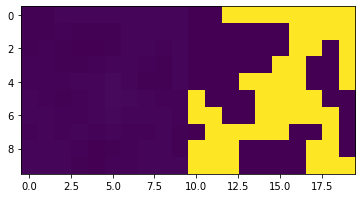

0.8697607758700432 48


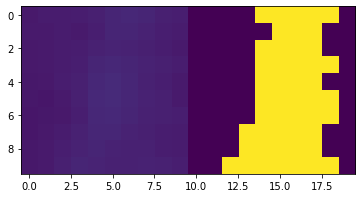

0.9413221791822329 35


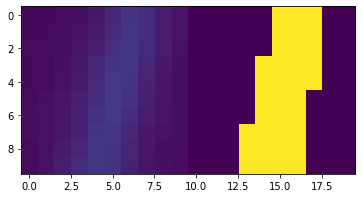

0.7887003053310758 20


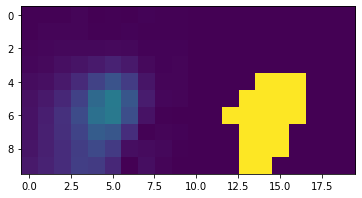

0.8652738301859279 31


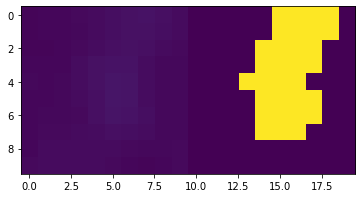

0.9370162333177827 36


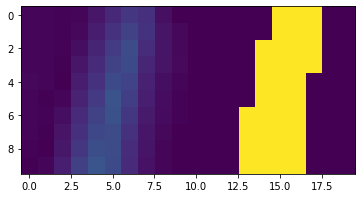

0.8708356089160372 31


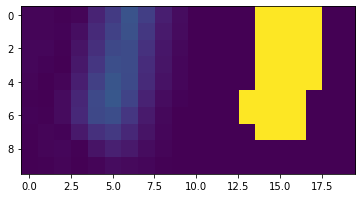

0.816496580927726 5


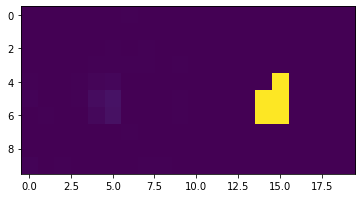

0.9062114727469615 31


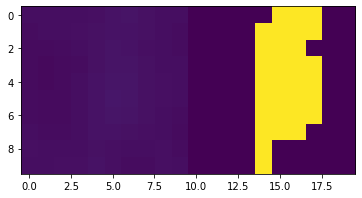

0.6831300510639732 12


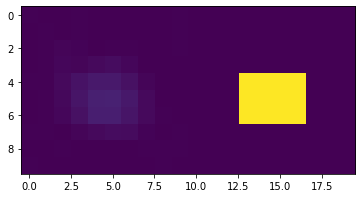

0.8827454623066487 41
1.0 2


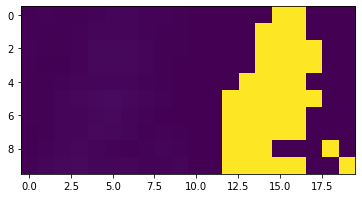

0 1
0.7612194874649082 20


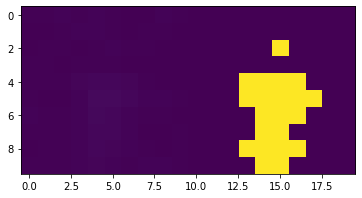

0.9188508395189422 36
1.0 2


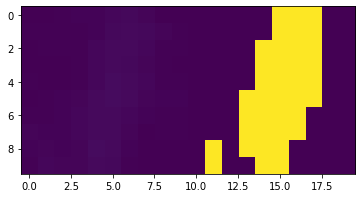

0.791771023167824 34


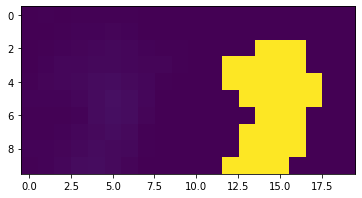

0.8404918108809976 49


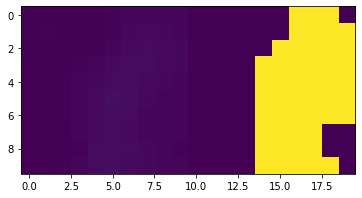

0.9501233856412494 32


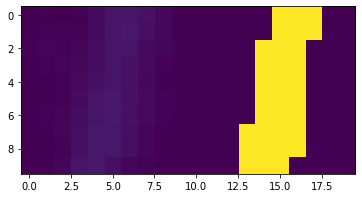

0.9391667407280757 33


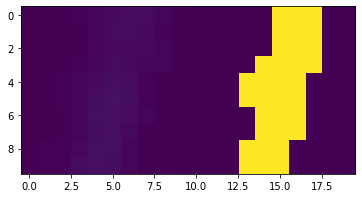

0.7531956703577404 29


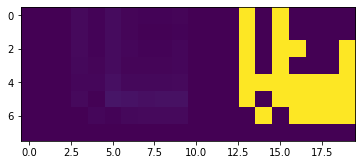

0.981097310923401 21


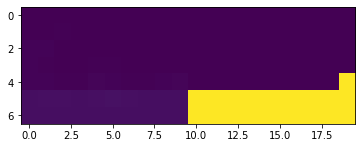

In [250]:
Imaxima = morphology.h_maxima(Idiff, 0.02)

idxs_r, idxs_c = np.where(Imaxima)
radius = 5

blobs = [ Idiff[r-radius:r+radius,c-radius:c+radius] for (r, c) in zip(idxs_r, idxs_c) ]

for blob in blobs:
    thr = filters.threshold_otsu(blob)
    mask = blob > thr
    regions = measure.regionprops(morphology.label(mask))
    for region in regions:
        print(region.eccentricity, region.area)
    plt.imshow(np.hstack([blob, np.float64(mask)]), vmin=0, vmax=1)
    plt.show()